# Creating a simple PDE model

In the [previous notebook](./1-an-ode-model.ipynb) we show how to create, discretise and solve an ODE model in pybamm. In this notebook we show how to create and solve a PDE problem, which will require meshing of the spatial domain.

As an example, we consider the problem of linear diffusion on a unit sphere,
\begin{equation*}
  \frac{\partial c}{\partial t} = \nabla \cdot (\nabla c),
\end{equation*}
with the following boundary and initial conditions:
\begin{equation*}
  \left.\frac{\partial c}{\partial r}\right\vert_{r=0} = 0, \quad \left.\frac{\partial c}{\partial r}\right\vert_{r=1} = 2, \quad \left.c\right\vert_{t=0} = 1.
\end{equation*}

As before, we begin by importing the pybamm library into this notebook, along with any other packages we require:


In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

## Setting up the model

As in the previous example, we start with a `pybamm.BaseModel` object and define our model variables. Since we are now solving a PDE we need to tell pybamm the domain each variable belongs to so that it can be discretised in space in the correct way. This is done by passing the keyword argument `domain`, and in this example we choose the domain "negative particle".

In [2]:
model = pybamm.BaseModel()

c = pybamm.Variable("Concentration", domain="negative particle")

Note that we have given our variable the (useful) name "Concentration", but the symbol representing this variable is simply `c`.

We then state out governing equations. Sometime it is useful to define intermediate quantities in order to express the governing equations more easily. In this example we define the flux, then define the rhs to be minus the divergence of the flux. The equation is then added to the dictionary `model.rhs`

In [3]:
N = -pybamm.grad(c)  # define the flux
dcdt = -pybamm.div(N)  # define the rhs equation

model.rhs = {c: dcdt}  # add the equation to rhs dictionary

Unlike ODE models, PDE models require both initial and boundary conditions. Similar to initial conditions, boundary conditions can be added using the dictionary `model.boundary_conditions`. Boundary conditions for each variable are provided as a dictionary of the form `{side: (value, type)`, where, in 1D, side can be "left" or "right", value is the value of the boundary conditions, and type is the type of boundary condition (at present, this can be "Dirichlet" or "Neumann").

In [4]:
# initial conditions
model.initial_conditions = {c: pybamm.Scalar(1)}

# boundary conditions
lbc = pybamm.Scalar(0)
rbc = pybamm.Scalar(2)
model.boundary_conditions = {c: {"left": (lbc, "Dirichlet"), "right": (rbc, "Neumann")}}

Note that in our example the boundary conditions take constant values, but the value can be any valid pybamm expression.

Finally, we add any variables of interest to the dictionary `model.variables`

In [5]:
model.variables = {"Concentration": c, "Flux": N}

## Using the model

Now the model is now completely defined all that remains is to discretise and solve. Since this model is a PDE we need to define the geometry on which it will be solved, and choose how to mesh the geometry and discretise in space.

### Defining a geometry and mesh

### Solving the model

In [6]:
# 1. Initialise an empty model ---------------------------------------------------------
model = pybamm.BaseModel()

# 2. Define variable -------------------------------------------------------------------
c = pybamm.Variable("Concentration", domain="negative particle")

# 3. State governing equations ---------------------------------------------------------
N = -pybamm.grad(c)  # flux
dcdt = -pybamm.div(N)

model.rhs = {c: dcdt}  # add equation to rhs dictionary

# 4. State boundary conditions ---------------------------------------------------------
lbc = pybamm.Scalar(0)
rbc = pybamm.Scalar(2)
model.boundary_conditions = {c: {"left": (lbc, "Dirichlet"), "right": (rbc, "Neumann")}}

# 5. State initial conditions ----------------------------------------------------------
model.initial_conditions = {c: pybamm.Scalar(1)}

# 6. State output variables ------------------------------------------------------------
model.variables = {"Concentration": c}

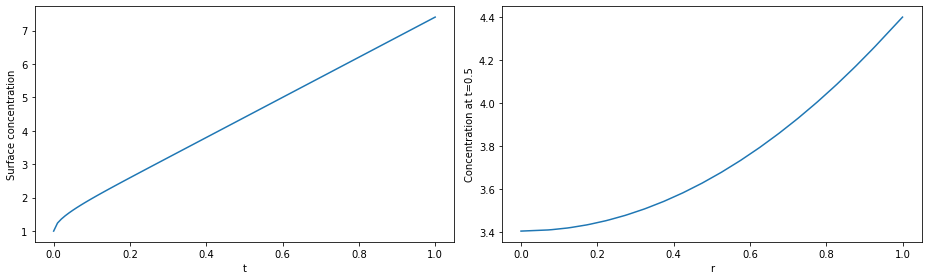

In [7]:
# define geometry
r = pybamm.SpatialVariable(
    "r", domain=["negative particle"], coord_sys="spherical polar"
)
geometry = {
    "negative particle": {
        "primary": {r: {"min": pybamm.Scalar(0), "max": pybamm.Scalar(1)}}
    }
}

# mesh and discretise
submesh_types = {"negative particle": pybamm.MeshGenerator(pybamm.Uniform1DSubMesh)}
var_pts = {r: 20}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)

spatial_methods = {"negative particle": pybamm.FiniteVolume()}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model)

# solve
solver = pybamm.ScipySolver()
t = np.linspace(0, 1, 100)
solution = solver.solve(model, t)

# post-process, so that the solution can be called at any time t or space r
# (using interpolation)
c = pybamm.ProcessedVariable(
    model.variables["Concentration"], solution.t, solution.y, mesh
)

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

ax1.plot(solution.t, c(solution.t, r=1))
ax1.set_xlabel("t")
ax1.set_ylabel("Surface concentration")
r = np.linspace(0, 1, 100)
ax2.plot(r, c(t=0.5, r=r))
ax2.set_xlabel("r")
ax2.set_ylabel("Concentration at t=0.5")
plt.tight_layout()
plt.show()

In the [next notebook](./3-negative-particle-problem.ipynb) we build on the example here to to solve the problem of diffusion in the negative electrode particle within the single particle model. In doing so we will also cover how to include parameters in a model. 